In [61]:
import tensorflow.keras

In [62]:
import argparse
import time
import json
import logging
import sys
import os
import math
import logging
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot
from sklearn import preprocessing

In [63]:
current_dir = current_dir = os.getcwd()

## Dataset path
train_FD001_path = current_dir +'/cmapss/train_FD001.csv'
test_FD001_path = current_dir +'/cmapss/test_FD001.csv'
RUL_FD001_path = current_dir+'/cmapss/RUL_FD001.txt'
FD001_path = [train_FD001_path, test_FD001_path, RUL_FD001_path]

train_FD002_path = current_dir +'/cmapss/train_FD002.csv'
test_FD002_path = current_dir +'/cmapss/test_FD002.csv'
RUL_FD002_path = current_dir +'/cmapss/RUL_FD002.txt'
FD002_path = [train_FD002_path, test_FD002_path, RUL_FD002_path]

train_FD003_path = current_dir +'/cmapss/train_FD003.csv'
test_FD003_path = current_dir +'/cmapss/test_FD003.csv'
RUL_FD003_path = current_dir +'/cmapss/RUL_FD003.txt'
FD003_path = [train_FD003_path, test_FD003_path, RUL_FD003_path]

train_FD004_path =current_dir +'/cmapss/train_FD004.csv'
test_FD004_path = current_dir +'/cmapss/test_FD004.csv'
RUL_FD004_path = current_dir +'/cmapss/RUL_FD004.txt'
FD004_path = [train_FD004_path, test_FD004_path, RUL_FD004_path]

In [78]:
data_path_list=dp_str = ["none", "FD001", "FD002", "FD003", "FD004"]
FD_path = ["none", FD001_path, FD002_path, FD003_path, FD004_path]
sequence_length = 30
sensor_drop = ['sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
piecewise_lin_ref=125 # Max RUl value
preproc=True
visualize=True

thres_type=None
thres_percentage=50 
flatten=False
visualize=True

In [79]:
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

## Assign columns name
cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
col_rul = ['RUL_truth']

train_FD = pd.read_csv(FD001_path[0], sep=' ', header=None, names=cols, index_col=False)
test_FD = pd.read_csv(FD001_path[1], sep=' ', header=None, names=cols, index_col=False)
RUL_FD = pd.read_csv(FD001_path[2], sep=' ', header=None, names=col_rul, index_col=False)


In [80]:
# Calculate RUL and append to train data
# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in train_FD['unit_nr'].unique():
    mapper[unit_nr] = train_FD['cycles'].loc[train_FD['unit_nr'] == unit_nr].max()

# calculate RUL = time.max() - time_now for each unit
train_FD['RUL'] = train_FD['unit_nr'].apply(lambda nr: mapper[nr]) - train_FD['cycles']
# piecewise linear for RUL labels
train_FD.loc[train_FD['RUL'] > piecewise_lin_ref, 'RUL'] = piecewise_lin_ref

# Cut max RUL ground truth
RUL_FD.loc[RUL_FD['RUL_truth'] > piecewise_lin_ref, 'RUL_truth'] = piecewise_lin_ref

# Exclude columns which only have NaN as value
cols_nan = train_FD.columns[train_FD.isna().any()].tolist()
cols_const = [col for col in train_FD.columns if len(train_FD[col].unique()) <= 2]

# Drop exclusive columns
train_FD = train_FD.drop(columns=cols_const + cols_nan + sensor_drop)
test_FD = test_FD.drop(columns=cols_const + cols_nan + sensor_drop)

print(train_FD)
print(test_FD)

       unit_nr  cycles    os_1    os_2  sensor_02  sensor_03  sensor_04  \
0            1       1 -0.0007 -0.0004     641.82    1589.70    1400.60   
1            1       2  0.0019 -0.0003     642.15    1591.82    1403.14   
2            1       3 -0.0043  0.0003     642.35    1587.99    1404.20   
3            1       4  0.0007  0.0000     642.35    1582.79    1401.87   
4            1       5 -0.0019 -0.0002     642.37    1582.85    1406.22   
...        ...     ...     ...     ...        ...        ...        ...   
20626      100     196 -0.0004 -0.0003     643.49    1597.98    1428.63   
20627      100     197 -0.0016 -0.0005     643.54    1604.50    1433.58   
20628      100     198  0.0004  0.0000     643.42    1602.46    1428.18   
20629      100     199 -0.0011  0.0003     643.23    1605.26    1426.53   
20630      100     200 -0.0032 -0.0005     643.85    1600.38    1432.14   

       sensor_07  sensor_08  sensor_09  sensor_11  sensor_12  sensor_13  \
0         554.36    2388

In [81]:
# Mix max normalize

            ## preprocessing(normailization for the neural networks)
min_max_scaler = preprocessing.MinMaxScaler()
            # for the training set
            # train_FD['cycles_norm'] = train_FD['cycles']
cols_normalize = train_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2', 'RUL'])

norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_FD[cols_normalize]),
                                         columns=cols_normalize,
                                         index=train_FD.index)
join_df = train_FD[train_FD.columns.difference(cols_normalize)].join(norm_train_df)
train_FD = join_df.reindex(columns=train_FD.columns)

            # for the test set
            # test_FD['cycles_norm'] = test_FD['cycles']
cols_normalize_test = test_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2'])
            # print ("cols_normalize_test", cols_normalize_test)
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_FD[cols_normalize_test]), columns=cols_normalize_test,
                                        index=test_FD.index)
test_join_df = test_FD[test_FD.columns.difference(cols_normalize_test)].join(norm_test_df)
test_FD = test_join_df.reindex(columns=test_FD.columns)
test_FD = test_FD.reset_index(drop=True)

In [82]:
        # Specify the columns to be used
        sequence_cols_train = train_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2', 'RUL'])
        sequence_cols_test = test_FD.columns.difference(['unit_nr', 'os_1', 'os_2', 'cycles'])


In [83]:
        ## generator for the sequences
        # transform each id of the train dataset in a sequence
        seq_gen = (list(gen_sequence(train_FD[train_FD['unit_nr'] == id], sequence_length, sequence_cols_train))
                   for id in train_FD['unit_nr'].unique())

        # generate sequences and convert to numpy array in training set
        seq_array_train = np.concatenate(list(seq_gen)).astype(np.float32)
        seq_array_train = seq_array_train.transpose(0, 2, 1) # shape = (samples, sensors, sequences)
        print("seq_array_train.shape", seq_array_train.shape)

        # generate label of training samples
        label_gen = [gen_labels(train_FD[train_FD['unit_nr'] == id], sequence_length, ['RUL'])
                     for id in train_FD['unit_nr'].unique()]
        label_array_train = np.concatenate(label_gen).astype(np.float32)

        # generate sequences and convert to numpy array in test set (only the last sequence for each engine in test set)
        seq_array_test_last = [test_FD[test_FD['unit_nr'] == id][sequence_cols_test].values[-sequence_length:]
                               for id in test_FD['unit_nr'].unique() if
                               len(test_FD[test_FD['unit_nr'] == id]) >= sequence_length]

        seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
        seq_array_test_last = seq_array_test_last.transpose(0, 2, 1) # shape = (samples, sensors, sequences)
        print("seq_array_test_last.shape", seq_array_test_last.shape)

        # generate label of test samples
        y_mask = [len(test_FD[test_FD['unit_nr'] == id]) >= sequence_length for id in test_FD['unit_nr'].unique()]
        label_array_test_last = RUL_FD['RUL_truth'][y_mask].values
        label_array_test = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)

seq_array_train.shape (17631, 14, 30)
seq_array_test_last.shape (100, 14, 30)


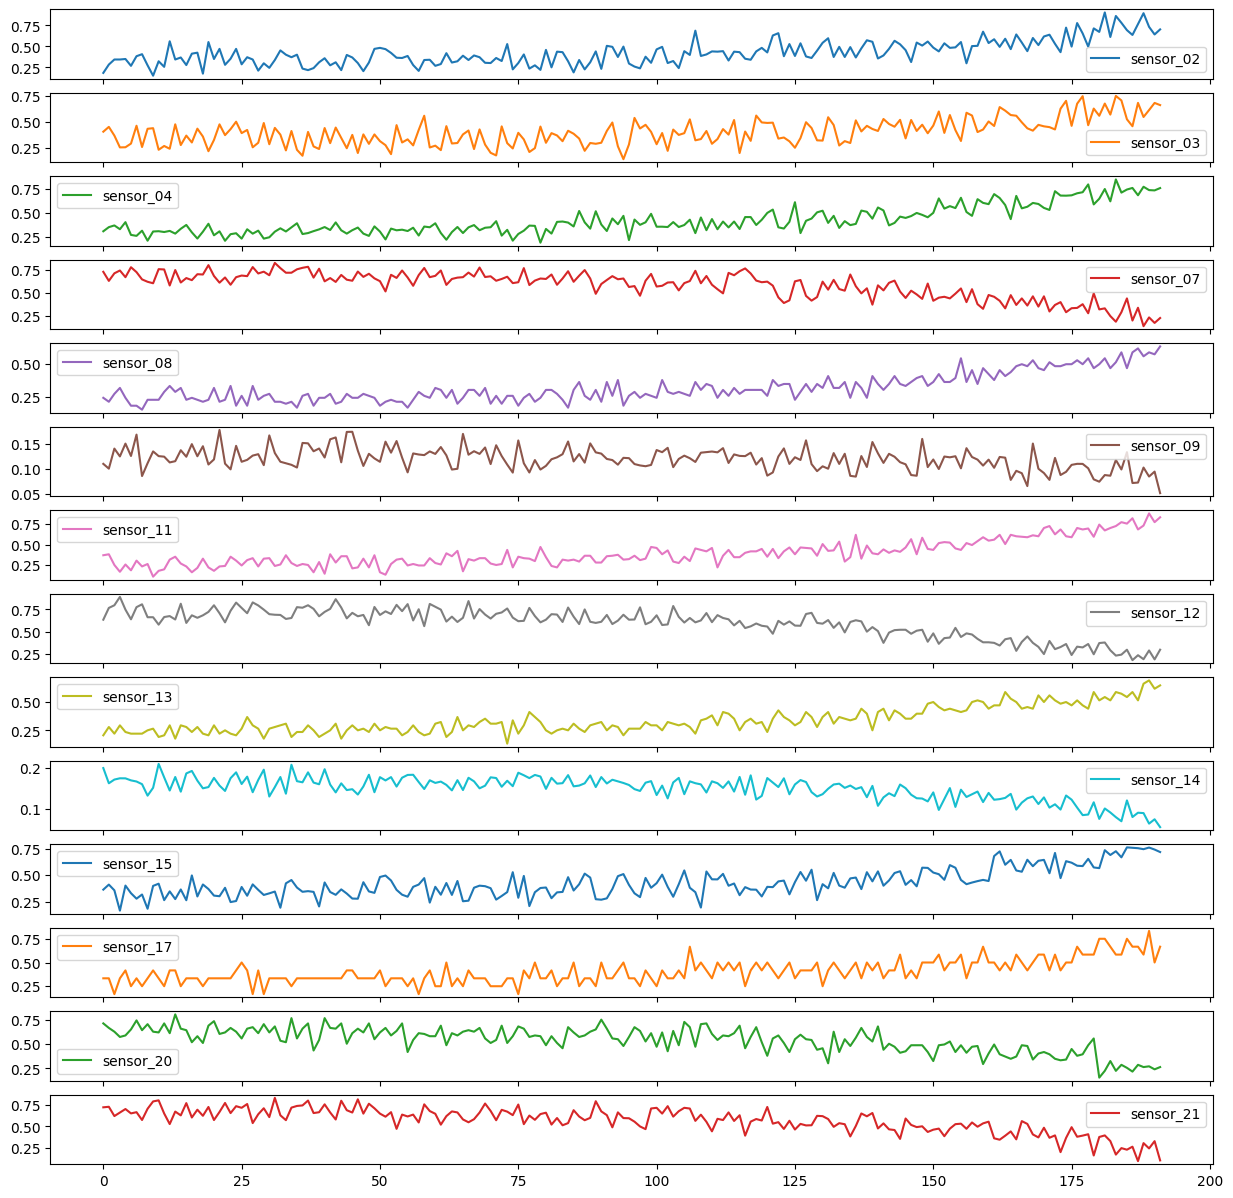

In [84]:
        if visualize == True:
            # R2F TS of the first engine
            pd.DataFrame(train_FD[train_FD['unit_nr'] == 1][sequence_cols_train].values,
                             columns=sequence_cols_train).plot(subplots=True, figsize=(15, 15))

            # The last sequences sliced from each TS (of the first engine)
            prop_cycle = plt.rcParams['axes.prop_cycle']
            colors = prop_cycle.by_key()['color']
            colors = colors + colors + colors

            seq_gen = (
            list(gen_sequence(train_FD[train_FD['unit_nr'] == id], sequence_length, sequence_cols_train))
            for id in train_FD['unit_nr'].unique())

            seq_list_engine = list(seq_gen)
            seq_engine_1_array = np.asarray(seq_list_engine[0])

            last_seq_engine_1_array = seq_engine_1_array[-1, :, :]


C:\ProgramData\anaconda3\envs\RUL\lib\site-packages\ipykernel_launcher.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  


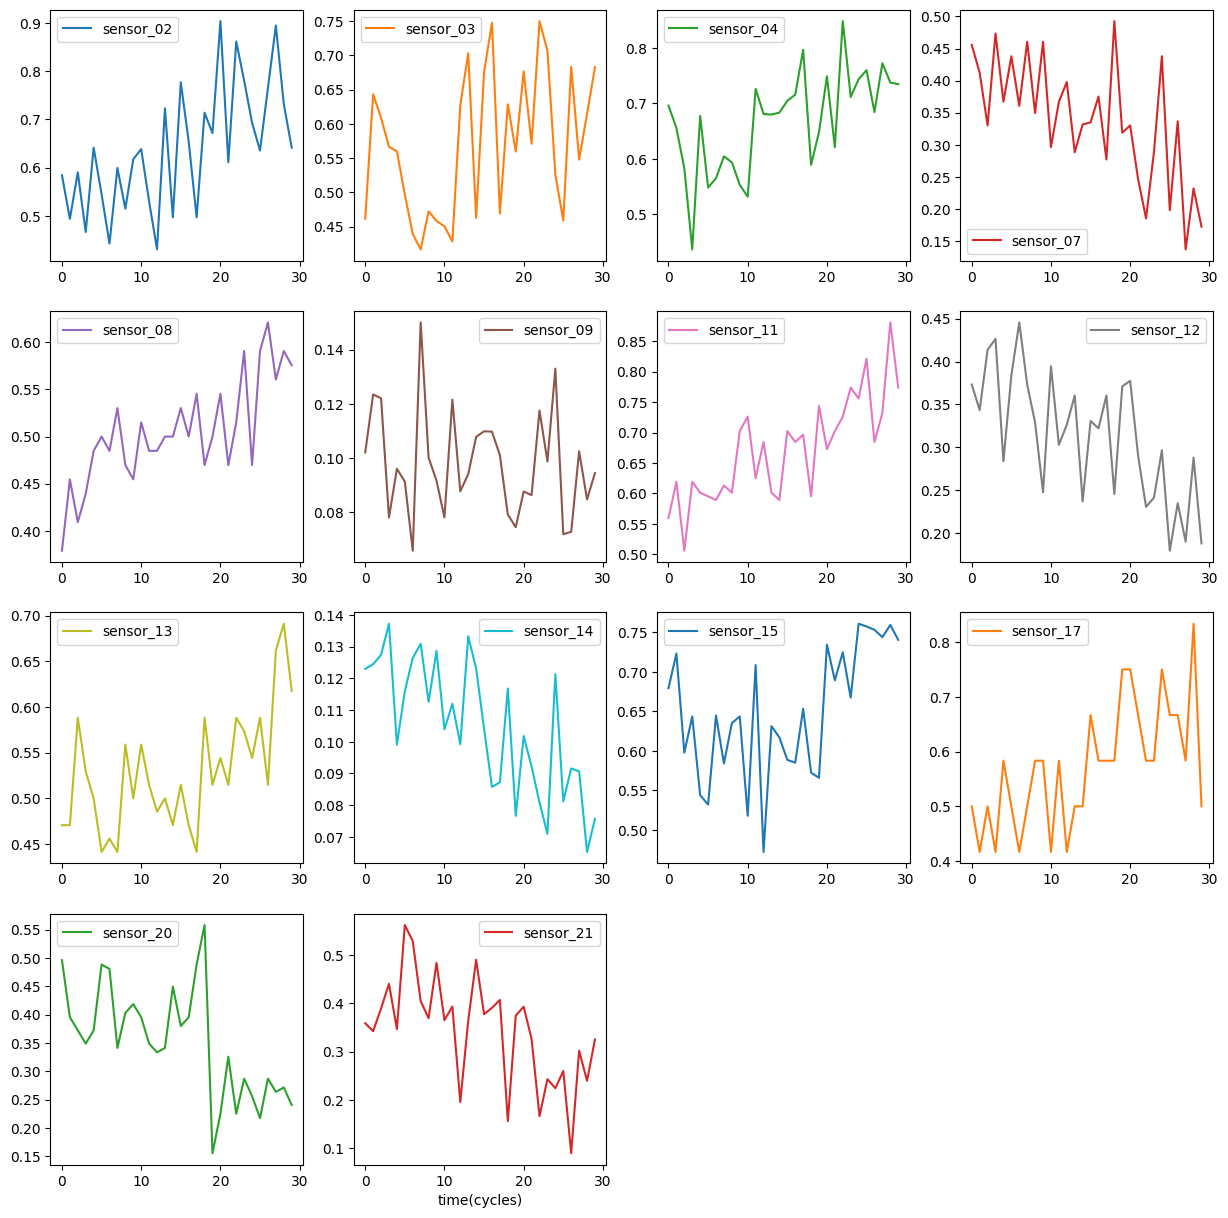

In [85]:
            fig_ts = plt.figure(figsize=(15, 15))
            for s in range(last_seq_engine_1_array.shape[1]):
                seq_s = last_seq_engine_1_array[:, s]
                # plt.subplot(last_seq_engine_1_array.shape[1],(s//4) + 1, (s%4)+1)
                plt.subplot(4, 4, s + 1)
                plt.plot(seq_s, "y", label=sequence_cols_train[s], color=colors[s])
                plt.legend()

            plt.xlabel("time(cycles)")
            plt.show()

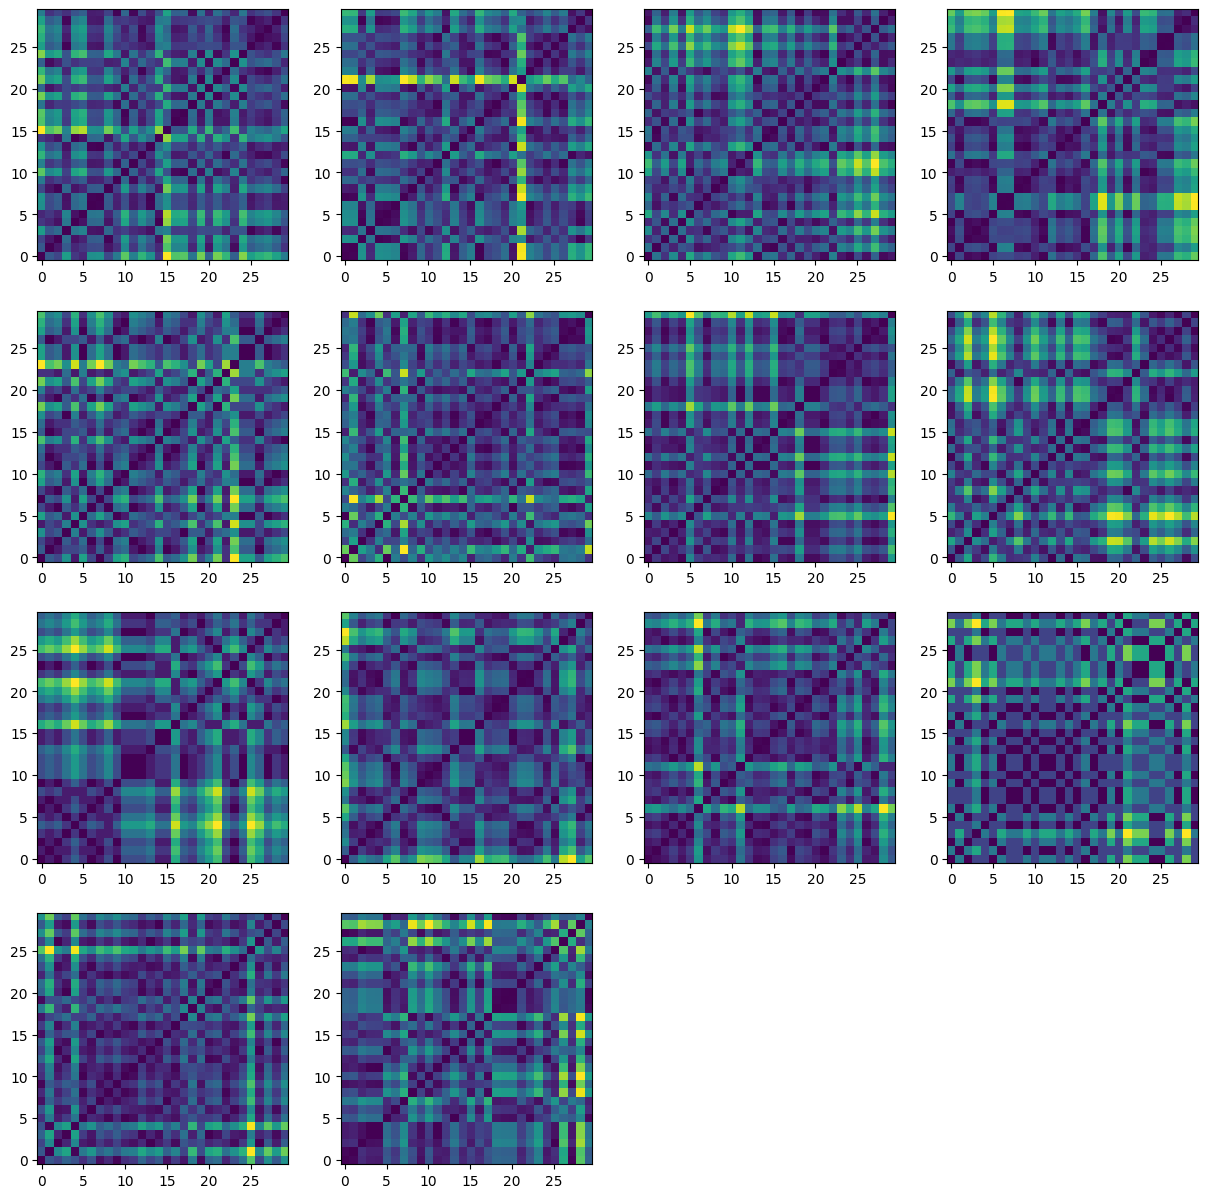

In [86]:
# Recurrence plot transformation for training samples
rp_train = RecurrencePlot(threshold=thres_type, percentage=thres_percentage,flatten=flatten)
rp_list = []

for idx in range(seq_array_train.shape[0]):
    temp_mts = seq_array_train[idx]
    X_rp_temp = rp_train.fit_transform(temp_mts)
    rp_list.append(X_rp_temp)

rp_train_samples = np.stack(rp_list, axis=0)

        # Recurrence plot transformation for test samples
rp_test = RecurrencePlot(threshold=thres_type, percentage=thres_percentage, flatten=flatten)
rp_list = []
for idx in range(seq_array_test_last.shape[0]):
    temp_mts = seq_array_test_last[idx]
    X_rp_temp = rp_test.fit_transform(temp_mts)
    rp_list.append(X_rp_temp)
rp_test_samples = np.stack(rp_list, axis=0)

        # Visualize RPs of the last sequences sliced from each TS (of the first engine)
if visualize == True:
    X_rp = rp_train_samples[-1]
    plt.figure(figsize=(15, 15))
    for s in range(len(X_rp)):
        plt.subplot(4, 4, s + 1)
        if flatten == True:
            img = np.atleast_2d(X_rp[s])
            plt.imshow(img, extent=(0, img.shape[1], 0, round(img.shape[1]/9)))
        else:
            plt.imshow(X_rp[s], origin='lower')
                # plt.legend()
    plt.show()



In [87]:
print(rp_train_samples)
print(rp_train_samples.shape)

[[[[0.         0.09939758 0.15963857 ... 0.15963857 0.02710843
    0.11445783]
   [0.09939758 0.         0.06024098 ... 0.06024098 0.07228915
    0.01506025]
   [0.15963857 0.06024098 0.         ... 0.         0.13253014
    0.04518074]
   ...
   [0.15963857 0.06024098 0.         ... 0.         0.13253014
    0.04518074]
   [0.02710843 0.07228915 0.13253014 ... 0.13253014 0.
    0.0873494 ]
   [0.11445783 0.01506025 0.04518074 ... 0.04518074 0.0873494
    0.        ]]

  [[0.         0.04621759 0.03727925 ... 0.14955306 0.10616961
    0.08327883]
   [0.04621759 0.         0.08349684 ... 0.19577065 0.1523872
    0.03706124]
   [0.03727925 0.08349684 0.         ... 0.11227381 0.06889036
    0.12055808]
   ...
   [0.14955306 0.19577065 0.11227381 ... 0.         0.04338345
    0.2328319 ]
   [0.10616961 0.1523872  0.06889036 ... 0.04338345 0.
    0.18944845]
   [0.08327883 0.03706124 0.12055808 ... 0.2328319  0.18944845
    0.        ]]

  [[0.         0.04287642 0.06076974 ... 0.02481434 

In [88]:
print("seq_array_train.shape", seq_array_train.shape)
print("seq_array_test_last.shape", seq_array_test_last.shape)
print(len(y_mask))
print(label_array_test.shape)

seq_array_train.shape (17631, 14, 30)
seq_array_test_last.shape (100, 14, 30)
100
(100, 1)


In [75]:
# LSTM 입력을 (samples, time steps, features) 형태로 변환
seq_array_train = seq_array_train.reshape(seq_array_train.shape[0], sequence_length, len(sequence_cols_train))
seq_array_test_last = seq_array_test_last.reshape(seq_array_test_last.shape[0], sequence_length, len(sequence_cols_test))

Epoch 1/50
391/391 [==============================] - 32s 77ms/step - loss: 1888.5802 - root_mean_squared_error: 42.1568 - val_loss: 240.0963 - val_root_mean_squared_error: 15.4950
Epoch 2/50
391/391 [==============================] - 31s 79ms/step - loss: 250.9000 - root_mean_squared_error: 15.8339 - val_loss: 336.5308 - val_root_mean_squared_error: 18.3448
Epoch 3/50
391/391 [==============================] - 30s 78ms/step - loss: 230.3820 - root_mean_squared_error: 15.1653 - val_loss: 174.4415 - val_root_mean_squared_error: 13.2076
Epoch 4/50
391/391 [==============================] - 29s 75ms/step - loss: 189.4276 - root_mean_squared_error: 13.7594 - val_loss: 175.5593 - val_root_mean_squared_error: 13.2499
Epoch 5/50
391/391 [==============================] - 28s 72ms/step - loss: 187.1101 - root_mean_squared_error: 13.6728 - val_loss: 238.4394 - val_root_mean_squared_error: 15.4415
Epoch 6/50
391/391 [==============================] - 29s 75ms/step - loss: 165.9526 - root_mean_sq

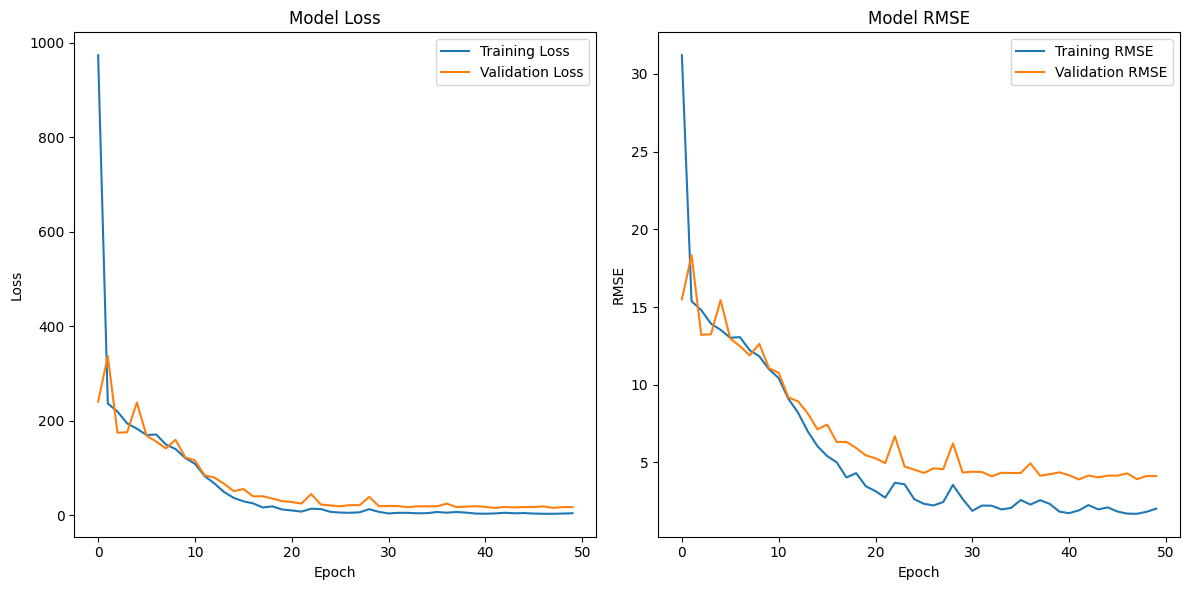

In [77]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(rp_train_samples, label_array_train, test_size=0.2, random_state=42)

# Build 2D-CNN LSTM model
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 50, 50, 1)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[RootMeanSquaredError()])

# Reshape data to fit the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], X_val.shape[3], 1)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Save the model
model_path = current_dir + '/2DCNNSLTM(Epochs-100,learning_rate=0.05, batch_size=32, sequence 50).h5'
model.save(model_path)

# Print model performance
val_loss, val_rmse = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation RMSE: {val_rmse}")

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation RMSE values
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(loc='upper right')

model.summary()

plt.tight_layout()
plt.show()

In [60]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_45 (TimeDis (None, None, 13, 13, 32)  320       
_________________________________________________________________
time_distributed_46 (TimeDis (None, None, 6, 6, 32)    0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, None, 4, 4, 64)    18496     
_________________________________________________________________
time_distributed_48 (TimeDis (None, None, 2, 2, 64)    0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, None, 256)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                61400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError

# Assuming rp_train_samples has shape (num_samples, sequence_length, features, features)
# and label_array_train has shape (num_samples, 1)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(rp_train_samples, label_array_train, test_size=0.2, random_state=42)

# Reshape data to fit the model (add channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], X_val.shape[3], 1)

# Build 2D-CNN BiLSTM model
model2 = Sequential()
model2.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 30, 30, 1)))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))
model2.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))
model2.add(TimeDistributed(Flatten()))
model2.add(Bidirectional(LSTM(50, activation='relu')))
model2.add(Dense(1))

# Compile the model with Mean Squared Error loss and RMSE metric
model2.compile(optimizer=Adam(learning_rate=0.05), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

# Train the model
history = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Save the model
model2_path = current_dir + '/temp_net_2DCNNBidnet.h5'
model2.save(model_path)

# Print model performance
val_loss, val_rmse = model2.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation RMSE: {val_rmse}")


Epoch 1/50
393/441 [=========================>....] - ETA: 4s - loss: 118390857074828.1250 - root_mean_squared_error: 8668118.8391

KeyboardInterrupt: 

In [23]:
model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 28, 28, 32)  320       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 14, 32)  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 12, 12, 64)  18496     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 6, 6, 64)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 2304)        0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               942000    
_________________________________________________________________
dense (Dense)                (None, 1)                 1